# Анализ датасета по игре Dota2

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

## Первый этап: применение градиентного бустинга для построения модели

Загрузим данные и посмотрим на них

In [2]:
data = pd.read_csv("features.csv", index_col="match_id")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97230 entries, 0 to 114406
Columns: 108 entries, start_time to barracks_status_dire
dtypes: float64(12), int64(96)
memory usage: 80.9 MB


Видим, что признаками являются числа, что освобождает нас от задачи кодирования

In [3]:
data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [4]:
data.shape

(97230, 108)

Проверим, у всех ли признаков заполнены значения

In [5]:
lines = data.shape[0]
not_full = dict()
for i in data.columns:
    if data[i].count() != lines:
        not_full[i] = data[i].count()

Выведем словарь с названием признака и числом заполненых объектов

In [6]:
not_full

{'first_blood_time': 77677,
 'first_blood_team': 77677,
 'first_blood_player1': 77677,
 'first_blood_player2': 53243,
 'radiant_bottle_time': 81539,
 'radiant_courier_time': 96538,
 'radiant_flying_courier_time': 69751,
 'radiant_first_ward_time': 95394,
 'dire_bottle_time': 81087,
 'dire_courier_time': 96554,
 'dire_flying_courier_time': 71132,
 'dire_first_ward_time': 95404}

Признак first_blood_time имеет пропущенные значения, так как не всегда событие "первая кровь"
успело произойти за первый 5 минут. По той же причине пустым является признак first_blood_team.
Признак radiant_bottle_time имеет пустые значения, скорее всего, из-за того, что данное событие 
(первое приобретение командой radiant предмета bottle) не успело произойти за первые 5 минут.

Удалим признаки, связанные с итогами матча

In [7]:
X = data.drop(columns=['duration', 'radiant_win', 'tower_status_radiant', 'tower_status_dire',
                      'barracks_status_radiant', 'barracks_status_dire'])
X.shape

(97230, 102)

Заменим пропуски в данных нулевыми значениями

In [8]:
X.fillna(0, inplace=True)

Удостоверимся, что занные действительно заполнены

In [9]:
not_full = dict()
for i in X.columns:
    if X[i].count() != lines:
        not_full[i] = X[i].count()

print(not_full)

{}


Выделим целевую переменную: 1 - если победила команда Radiant, 0 - иначе

In [10]:
y = data.radiant_win

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

In [12]:
from sklearn.model_selection import KFold, cross_val_score

Проведём кросс-валидацию на пяти блоках и оценим качество модели в зависимости от 
количества деревьев (10, 20, 30)

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grad = GradientBoostingClassifier(n_estimators=10, random_state=42)
start_time = datetime.datetime.now()
print('Cross validation scores:', cross_val_score(grad, X, y, cv=kf, scoring='roc_auc'))
print('Time elapsed:', datetime.datetime.now() - start_time)

Cross validation scores: [0.66383799 0.66635457 0.66360048 0.66529818 0.66516222]
Time elapsed: 0:01:07.394861


In [14]:
grad = GradientBoostingClassifier(n_estimators=20, random_state=42)
start_time = datetime.datetime.now()
print('Cross validation scores:', cross_val_score(grad, X, y, cv=kf, scoring='roc_auc'))
print('Time elapsed:', datetime.datetime.now() - start_time)

Cross validation scores: [0.68083889 0.68272733 0.67969876 0.6834932  0.6855512 ]
Time elapsed: 0:02:19.345237


In [15]:
grad = GradientBoostingClassifier(n_estimators=30, random_state=42)
start_time = datetime.datetime.now()
print('Cross validation scores:', cross_val_score(grad, X, y, cv=kf, scoring='roc_auc'))
print('Time elapsed:', datetime.datetime.now() - start_time)

Cross validation scores: [0.68892093 0.68934663 0.68712298 0.69180598 0.69283583]
Time elapsed: 0:03:14.934770


Оценим качество лучшей модели на кривой ROC-AUC

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [17]:
grad = GradientBoostingClassifier(n_estimators=30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y)
grad.fit(X_train, y_train)
print('roc auc score:', roc_auc_score(y_test, grad.predict_proba(X_test)[:,1]))

roc auc score: 0.6934463693074868


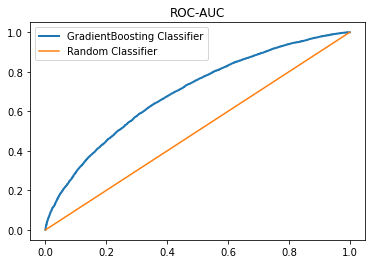

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, grad.predict_proba(X_test)[:,1])
lw = 2
plt.plot(fpr, tpr, lw=lw, label='GradientBoosting Classifier')
plt.plot(np.linspace(0,1), np.linspace(0,1), label='Random Classifier')
plt.title('ROC-AUC')
plt.legend()

## Выводы по первому этапу

1) Незаполненными признаками оказались следующие:
'first_blood_time', 'first_blood_team', 'first_blood_player1',
 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time',
 'radiant_flying_courier_time', 'radiant_first_ward_time',
 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time',
 'dire_first_ward_time'.
 
 2) Столбец с целевой переменной имеет название 'radiant_win'.
 Он принимает значение 1, если выиграла команда Radiant и 0 иначе.
 
 3) Кросс-валидация для градиентного бустинга при n_estimators=30 проводилась порядка
 трёх минут на далеко не топовом железе. Качество при этом было получено около 69%.
 
 4) Как можно заметить, полученное качество классификатора трудно назвать хорошим, но оно
 по крайней мере лучше случайного гадания. При увеличении параметра n_estimators вполне можно 
 добиться правильности в 70%, но при этом значительно увеличится время обучения. Подобная 
 невысокая точность может говорить о недообучении или отсутвии как таковой зависимости между 
 исходными признаками и целевой переменной. Правильно настроенные признаки дают гарантированный 
 прирост в качестве прогнозирования, в отличии от подбора гиперпараметров модели, которой вряд ли даст 
 прирост и на 5%. Для ускорения обучения при увеличении деревьев можно попробовать обучаться не 
 на всей выборке, а разбить её на несколько случайных подмножеств и провести валидацию отдельно
 на каждом из них. Также можно попробовать ограничить глубину дерева.

Попробуем усложнить модель, добавив больше деревьев

In [19]:
grad = GradientBoostingClassifier(n_estimators=100, random_state=42)
grad.fit(X_train, y_train)
print('roc auc score:', roc_auc_score(y_test, grad.predict_proba(X_test)[:,1]))

roc auc score: 0.7114777119277474


In [20]:
grad = GradientBoostingClassifier(n_estimators=250, random_state=42)
grad.fit(X_train, y_train)
print('roc auc score:', roc_auc_score(y_test, grad.predict_proba(X_test)[:,1]))

roc auc score: 0.7219627351915582


In [21]:
grad = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
grad.fit(X_train, y_train)
print('roc auc score:', roc_auc_score(y_test, grad.predict_proba(X_test)[:,1]))

roc auc score: 0.71790704233638


Таким образом, усложнение модели может дать прирост к качеству, но за болешее время.

## Второй этап: применение логистической регрессии для построения модели

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

Нормируем признаки, так как линейные модели чувствительны к масштабу данных

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
logit = LogisticRegression(random_state=42)
start_time = datetime.datetime.now()
print('Cross validation scores:', cross_val_score(logit, X_scaled, y, cv=kf, scoring='roc_auc'))
print('Time elapsed:', datetime.datetime.now() - start_time)

Cross validation scores: [0.71461609 0.71617193 0.71618261 0.71737575 0.71826417]
Time elapsed: 0:00:08.428245


Как нетрудно видеть, мы получили качество, лучшее чем для градиентного бустинга за значительно меньшее время.
Более того, нам даже не пришлось для этого настраивать гиперпараметры модели. Теперь же найдём оптимальный параметр C.

In [25]:
c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=kf, random_state=42, n_jobs=-1, scoring='roc_auc')
logit_searcher.fit(X_scaled, y)

LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     class_weight=None,
                     cv=KFold(n_splits=5, random_state=42, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=42, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

In [26]:
logit_searcher.C_

array([0.01096681])

Построим график зависимости скоринга на крос-валидации от параметра C

Text(0.5, 1.0, 'C values')

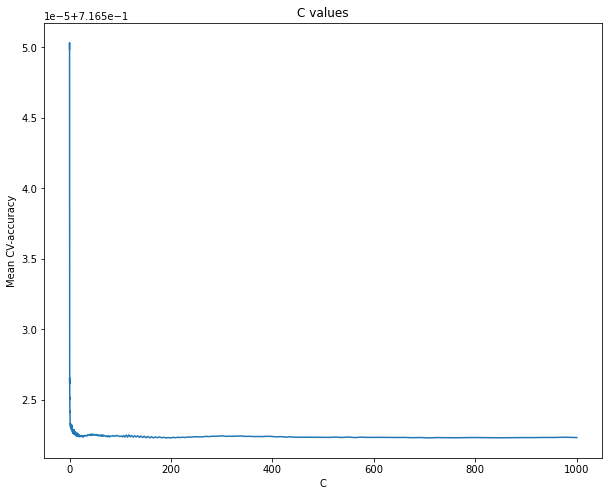

In [27]:
plt.figure(figsize=(10,8))
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.title('C values')

Выделим наилучший участок

(0.0, 10.0)

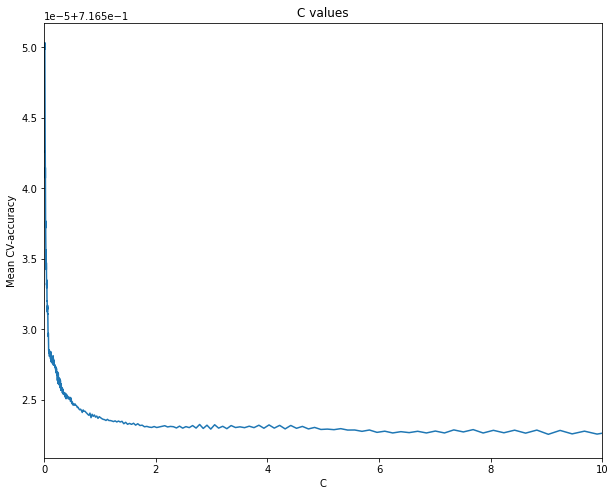

In [28]:
plt.figure(figsize=(10,8))
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy');
plt.title('C values')
plt.xlim(0,10)
#plt.ylim(0,1)

Видим, что изменение параметра C практически не оказывает влияния на качество модели. Примем C=0.01.

In [29]:
logit = LogisticRegression(C=0.01, random_state=42)
start_time = datetime.datetime.now()
print('Cross validation scores:', cross_val_score(logit, X_scaled, y, cv=kf, scoring='roc_auc'))
print('Time elapsed:', datetime.datetime.now() - start_time)

Cross validation scores: [0.71464464 0.71617921 0.71624672 0.71735016 0.7183287 ]
Time elapsed: 0:00:08.628489


Качество модели несколько лучше градиентного бустинга, однако при усложнении модели 
бустинга можно получить сравнимое качество. Скорость обучения значительно лучше у логистической 
регрессии. 

In [56]:
categorical_type = ['lobby_type', 'r1_hero', 'r2_hero', 'r3_hero', 
                    'r4_hero', 'r5_hero', 'd1_hero', 'd2_hero', 'd3_hero', 'd4_hero', 'd5_hero']

Уберём из выборки категориальные признаки

In [57]:
X_without_cat = X.copy()
X_without_cat = X_without_cat.drop(categorical_type, axis=1)

Проверим заполненность признаков

In [58]:
not_full = dict()
for i in X_without_cat.columns:
    if X_without_cat[i].count() != lines:
        not_full[i] = X_without_cat[i].count()

print(not_full)

{}


Масштабируем признаки

In [59]:
X_scaled = scaler.fit_transform(X_without_cat)

In [61]:
logit = LogisticRegression(C=0.01, random_state=42)
cross_val_score(logit, X_scaled, y, cv=kf, scoring='roc_auc')

array([0.7145036 , 0.71621974, 0.71627984, 0.71725108, 0.71854174])

Качество осталось на прежнем уровне. Скорее всего, удалённые признаки не вносили весомый вклад в параметры модели.
Попробуем иначе их закодировать. Для этого вычислим количество доступных героев.

In [35]:
print('r1_hero:', np.unique(data.r1_hero).max())
print('r2_hero:', np.unique(data.r2_hero).max())
print('r3_hero:', np.unique(data.r3_hero).max())
print('r4_hero:', np.unique(data.r4_hero).max())
print('r5_hero:', np.unique(data.r5_hero).max())
print('d1_hero:', np.unique(data.d1_hero).max())
print('d2_hero:', np.unique(data.d2_hero).max())
print('d3_hero:', np.unique(data.d3_hero).max())
print('d4_hero:', np.unique(data.d4_hero).max())
print('d5_hero:', np.unique(data.d5_hero).max())

r1_hero: 112
r2_hero: 112
r3_hero: 112
r4_hero: 112
r5_hero: 112
d1_hero: 112
d2_hero: 112
d3_hero: 112
d4_hero: 112
d5_hero: 112


Закодируем категориальные признаки при помощи подхода "мешок слов"

In [36]:
X_pick = np.zeros((X.shape[0], 112))
r_cols = [2,10,18,26,32]
d_cols = [40,48,56,64,72]
for i, match_id in enumerate(X.index):
    for p in r_cols:
        X_pick[i, X.iloc[i, p]-1] = 1
    for l in d_cols:
        X_pick[i, X.iloc[i, l]-1] = -1

Заменяем категориальные признаки закодированными

In [37]:
X_without_cat = X.copy()
X_without_cat = X_without_cat.drop(categorical_type, axis=1)
X_with_cat = np.hstack([X_without_cat.values, X_pick])

Масштабируем признаки

In [38]:
X_scaled = scaler.fit_transform(X_with_cat)

In [39]:
cross_val_score(logit, X_scaled, y, cv=kf, scoring='roc_auc')

array([0.72732602, 0.72852997, 0.73033088, 0.73156684, 0.73092311])

Сохраним модель для дальнейшего использования

In [40]:
model = LogisticRegression(C=0.01, random_state=42)
model.fit(X_scaled, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Видим, что качество классификатора улучшилось - 73%. Выбор персонажа - это важный признак.
Скорее всего, некоторых героев используют чаще из-за более сильных характеристик. Может быть, 
есть связки героев, которые работают более эффективно.

Оценим качество лучшей модели на кривой ROC-AUC

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)
logit = LogisticRegression(C=0.01, random_state=42)
logit.fit(X_train, y_train)
roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])

0.7314530835695449

In [42]:
fpr, tpr, thresholds = roc_curve(y, logit.predict_proba(X_scaled)[:,1])

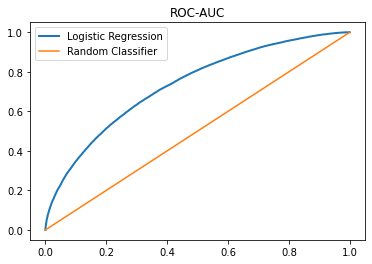

In [43]:
lw = 2
plt.plot(fpr, tpr, lw=lw, label='Logistic Regression')
plt.plot(np.linspace(0,1), np.linspace(0,1), label='Random Classifier')
plt.title('ROC-AUC')
plt.legend()

## Выводы по второму этапу

1) Качество логистической регрессии для полного набора данных получилось 71%. Этот показатель чуть выше показателя градиентного бустинга при количестве деревьев равных 30 - 69%. Разница в качестве, на мой взгляд, обеспечена недостаточной сложностью модели градиентного бустинга, ведь при количестве деревьев равным 250 мы также получим качество в 71%. Время обучения логистической регрессии значительно быстрее времени обучения бустинга. 

2) Удаление категориальных признаков незначительно уменьшило качество классификатора. Данный признак не вносил существенного вклада в параметры модели. 

3) Всего насчитано 112 идентификаторов героев.

4) При добавлении признаков из "мешка слов" качество модели улучшилось - 73%. Признак выбора героя оказался важным, ведь каждый из них имеет свои характеристики, следовательно, некоторые герои выделяются среди других.

5) Следующим этапом будет проверка лучшей модели для тестовой выборки. Будем использовать логистическую регрессию с параметром C=0.01.

## Тестирование лучшей модели

Загрузка данных

In [44]:
# надо сохранить модель
data = pd.read_csv('features_test.csv', index_col="match_id")
data.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,
6,1430287923,0,93,4,1103,1089,8,0,1,9,...,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1430293357,1,20,2,556,570,1,0,0,9,...,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1430301774,1,112,2,751,808,1,0,0,13,...,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1430323933,1,27,3,708,903,1,1,1,11,...,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1430331112,1,39,4,1259,661,4,0,0,9,...,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


Подготовка данных

In [45]:
print('r1_hero:', np.unique(data.r1_hero).max())

r1_hero: 112


In [46]:
data.fillna(0, inplace=True)

X_without_cat = data.copy()

"Мешок слов"

In [47]:
X_without_cat.shape

(17177, 102)

In [48]:
X_pick = np.zeros((X_without_cat.shape[0], 112))
r_cols = [2,10,18,26,32]
d_cols = [40,48,56,64,72]
for i, match_id in enumerate(X_without_cat.index):
    for p in r_cols:
        X_pick[i, X_without_cat.iloc[i, p]-1] = 1
    for l in d_cols:
        X_pick[i, X_without_cat.iloc[i, l]-1] = -1

In [49]:
X_without_cat = X_without_cat.drop(categorical_type, axis=1)
X_with_cat = np.hstack([X_without_cat.values, X_pick])

Масштабирование признаков. Отличием является применение метода transform, а не fit_transform, так как мы уже обучили scaler на тренировочной выборке

In [50]:
X_test = scaler.transform(X_with_cat)

Получим предсказания модели и сохраним их в файл

In [51]:
prediction = model.predict_proba(X_test)[:,1]

In [52]:
match_id = data.index

In [53]:
with open('answer.csv', 'w') as f:
    f.write('match_id,radiant_win\n')
    for i, j in zip(match_id, prediction):
        f.write(str(i) + ',' + str(j) + '\n')

Минимальное значение прогноза

In [54]:
prediction.min()

0.005329525456725892

Максимальное значение прогноза

In [55]:
prediction.max()

0.9908850776975885